## Proyecto para clasificar la subjetividad de un texto

Se extraen textos con la categoria correspondientes de objetividad y subjetividad, **objetivo 1 subjetivo 0**
, donde en total son 20000 datos de estos, traduccidos de 2 fuentes distintas, que son referenciados de las siguientes fuentes.


1.   "https://paperswithcode-com.translate.goog/dataset/czech-subjectivity-dataset?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es-419"
2.   "https://www.cs.cornell.edu/people/pabo/movie-review-data/"


se utilizo traductor para trasladarlo al lenguaje español. trambien agregar que se utilizo software de terceros para la traduccion, especificamente de la siguiente pagina.



*   https://www.onlinedoctranslator.com/es/translationform

Agradecimientos a los creados de estas fuentes y software que facilitaron el proceso obtencion y transformacion.

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('datos.csv',header=0)
print(data.head())

   Id                                              Texto  label Categoría
0   0  La película comienza en el pasado, donde un jo...      1  objetivo
1   1  emergiendo de la psique humana y mostrando car...      1  objetivo
2   2  despreciando la insistencia de su madre de que...      1  objetivo
3   3  amitabh no puede creer la junta directiva y su...      1  objetivo
4   4  ella, entre otras excentricidades, habla con u...      1  objetivo


# Normalizacion de datos

se importa nltk y regex para la normalizacion ya sea para "**stopwords**", "**lematizacion**", y "**stemming**" y se descargar los corpus para cada caso.

In [ ]:
!pip install unidecode
!pip install --upgrade tensorflow tensorboard
%load_ext tensorboard
!rm -rf ./logs/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 53.9 MB/s eta 0:00:00


In [ ]:
import nltk
import re
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

se inicializan cada objetivo para utilizarlo en la funcion definida "normalizacion" y se utiliza los stopword para español

In [ ]:
stopwords_es = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
from nltk.tokenize import texttiling
def normalizacion(text):
    texto_unicode = unidecode(text.lower())
    text = re.sub(r'[,.¿?!¡()"\'\'%]', '', texto_unicode)
    palabras_tokenizadas = nltk.word_tokenize(text.lower())
    palabras_sin_stopwords = [word for word in palabras_tokenizadas if word not in stopwords_es]
    palabras_lematizadas = [lemmatizer.lemmatize(word) for word in palabras_sin_stopwords]
    palabras_con_stemmed = [stemmer.stem(word) for word in palabras_lematizadas]
    return " ".join(palabras_lematizadas)

In [ ]:
primer_dato = data.iloc[0]['Texto']
print(primer_dato)

La película comienza en el pasado, donde un joven llamado Sam intenta salvar a una celebridad de un cazador.


In [ ]:
print(normalizacion(primer_dato))

pelicula comienza pasado joven llamado sam intenta salvar celebridad cazador


In [ ]:
data['Texto_nuevo'] = data['Texto'].apply(normalizacion)
print(data['Texto_nuevo'])

0        pelicula comienza pasado joven llamado sam int...
1        emergiendo psique humana mostrando caracterist...
2        despreciando insistencia madre siguiera vida m...
3        amitabh puede creer junta directiva mente llen...
4        excentricidades habla pequena roca gertrude si...
                               ...                        
19995    tampoco muchas cosas reirse aqui realmente voy...
19996    consecuencias claras momento aparecio primera ...
19997         clasicos comedia checa capaces encontrar fan
19998            buen respiro beneficia alivio humoristico
19999    comedia policiaca tan relajada sentirse bien d...
Name: Texto_nuevo, Length: 20000, dtype: object


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           20000 non-null  int64 
 1   Texto        20000 non-null  object
 2   label        20000 non-null  int64 
 3   Categoría    20000 non-null  object
 4   Texto_nuevo  20000 non-null  object
dtypes: int64(2), object(3)
memory usage: 781.4+ KB


# Set de entrenamiento y de validacion
Separacion del data set en datos de entrenamiento y datos de validacion, con un porcentaje de test del 10% y un random_state de 42

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(data, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)
print(len(train), 'ejemplos entrenamiento')
print(len(val), 'ejemplos validacion')
print(len(test), 'ejemplos de testeo')

16200 ejemplos entrenamiento
1800 ejemplos validacion
2000 ejemplos de testeo


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
# Crear conjuntos de datos con tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train['Texto_nuevo'], train['label']))
test_dataset = tf.data.Dataset.from_tensor_slices((test['Texto_nuevo'], test['label']))

# Aplicar transformaciones a los conjuntos de datos
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'frigo jugando golf accidentalmente cae inconsciente'
 b'nuevo insomnio nueva version sorprendentemente fiel frio predecesor elige tomar propia direccion emplea cambios quedan bien lugar impusieron bien sensibilidades comerciales'
 b'legendario puente cerca arnhem paises bajos permanecio manos alemanas tiempo']

labels:  [1 0 1]


In [ ]:
VOCAB_SIZE = 30000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda texto, label: texto))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'pelicula', 'ma', 'si', 'historia', 'vida', 'solo',
       'ano', 'ser', 'tan', 'puede', 'tambien', 'do', 'despues', 'vez',
       'tiempo', 'mundo', 'gran', 'hombre'], dtype='<U89')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 7436,  2928,  4010,  1096,  1000,  9281,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0],
       [   55,  3566,    59,   179,   754,  1384,  1696,  5824,  3287,
          617,   191,   305,  7570,  1344,  1569,    22,    35, 23201,
           22,  6827,  2781,     0,     0,     0,     0,     0,     0],
       [ 1314,  3486,   483, 29464,  2143,  3703,  8740,   509,  5530,
           16,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
          validation_data=test_dataset,
          validation_steps=30)

Epoch 1/10
507/507 [==============================] - 58s 79ms/step - loss: 0.6927 - accuracy: 0.5375 - val_loss: 0.6923 - val_accuracy: 0.5792
Epoch 2/10
507/507 [==============================] - 19s 37ms/step - loss: 0.6912 - accuracy: 0.5907 - val_loss: 0.6901 - val_accuracy: 0.6198
Epoch 3/10
507/507 [==============================] - 15s 30ms/step - loss: 0.6859 - accuracy: 0.6485 - val_loss: 0.6811 - val_accuracy: 0.7125
Epoch 4/10
507/507 [==============================] - 14s 28ms/step - loss: 0.6612 - accuracy: 0.7430 - val_loss: 0.6371 - val_accuracy: 0.7510
Epoch 5/10
507/507 [==============================] - 14s 28ms/step - loss: 0.5624 - accuracy: 0.8093 - val_loss: 0.5224 - val_accuracy: 0.8062
Epoch 6/10
507/507 [==============================] - 14s 28ms/step - loss: 0.4496 - accuracy: 0.8450 - val_loss: 0.4700 - val_accuracy: 0.8198
Epoch 7/10
507/507 [==============================] - 14s 27ms/step - loss: 0.3935 - accuracy: 0.8635 - val_loss: 0.4586 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

63/63 [==============================] - 1s 8ms/step - loss: 0.4457 - accuracy: 0.8230
Test Loss: 0.4457293152809143
Test Accuracy: 0.8230000138282776


In [ ]:
sample_text = ('La última película de ese director fue un desastre, no se la recomendaría a nadie')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[0.11905617]]


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

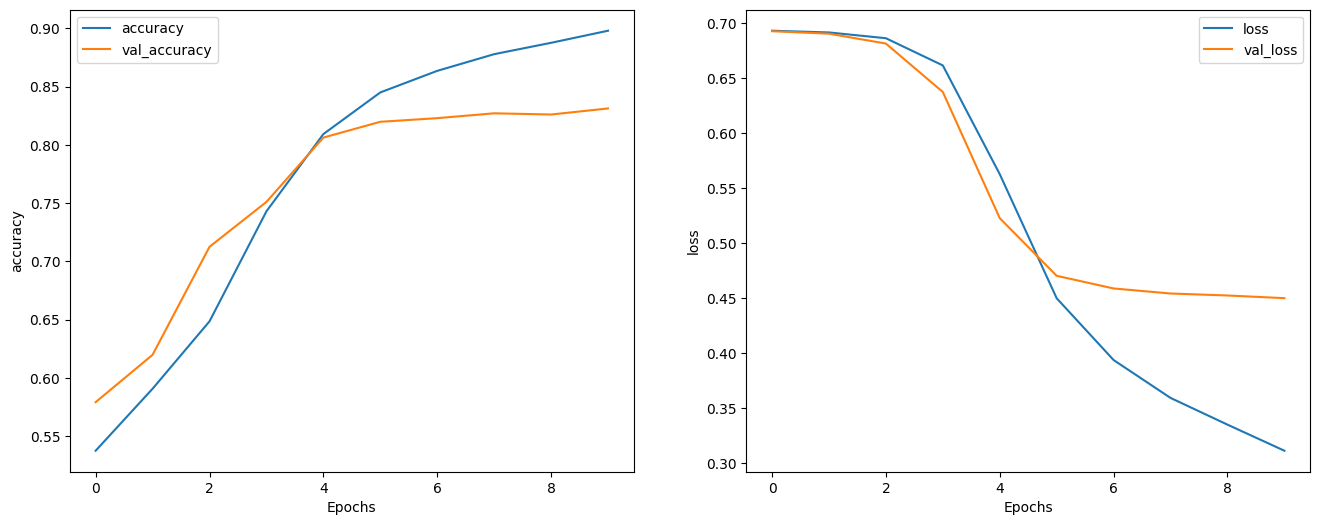

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
data_noticias = pd.read_csv('datos_noticias.csv',header=0,sep='|')

In [ ]:
data_noticias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60166 entries, 0 to 60165
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             60166 non-null  object 
 1   Titulo                 60166 non-null  object 
 2   Contexto               58732 non-null  object 
 3   Fecha                  60154 non-null  object 
 4   Categoria              59595 non-null  object 
 5   Contenido              60166 non-null  object 
 6   Sitio web              60166 non-null  object 
 7   Sentimiento titulo     60166 non-null  float64
 8   Sentimiento contexto   60166 non-null  float64
 9   Sentimiento contenido  60166 non-null  float64
dtypes: float64(3), object(7)
memory usage: 4.6+ MB


In [ ]:
data_noticias = data_noticias.dropna(subset=['Contexto'])

In [ ]:
data_noticias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58732 entries, 0 to 60165
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             58732 non-null  object 
 1   Titulo                 58732 non-null  object 
 2   Contexto               58732 non-null  object 
 3   Fecha                  58720 non-null  object 
 4   Categoria              58161 non-null  object 
 5   Contenido              58732 non-null  object 
 6   Sitio web              58732 non-null  object 
 7   Sentimiento titulo     58732 non-null  float64
 8   Sentimiento contexto   58732 non-null  float64
 9   Sentimiento contenido  58732 non-null  float64
dtypes: float64(3), object(7)
memory usage: 4.9+ MB


In [ ]:
texto_normalizado_titulo = np.array(data_noticias['Titulo'].apply(normalizacion))

In [ ]:
texto_normalizado_contexto = np.array(data_noticias['Contexto'].astype(str).apply(normalizacion))
texto_normalizado_contenido = np.array(data_noticias['Contenido'].astype(str).apply(normalizacion))

In [ ]:
predicciones_titulo = model.predict(texto_normalizado_titulo)

1836/1836 [==============================] - 13s 7ms/step


In [ ]:
predicciones_contexto = model.predict(texto_normalizado_contexto)

1836/1836 [==============================] - 15s 8ms/step


In [ ]:
predicciones_contenido = model.predict(texto_normalizado_contenido)

1836/1836 [==============================] - 53s 29ms/step


In [ ]:
data_noticias['Subjetividad titulo'] = predicciones_titulo
data_noticias['Subjetividad contexto'] = predicciones_contexto
data_noticias['Subjetividad contenido'] = predicciones_contenido

In [ ]:
data_noticias = data_noticias.drop(columns=['Unnamed: 0'])

In [ ]:
data_noticias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58732 entries, 0 to 60165
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Titulo                  58732 non-null  object 
 1   Contexto                58732 non-null  object 
 2   Fecha                   58720 non-null  object 
 3   Categoria               58161 non-null  object 
 4   Contenido               58732 non-null  object 
 5   Sitio web               58732 non-null  object 
 6   Sentimiento titulo      58732 non-null  float64
 7   Sentimiento contexto    58732 non-null  float64
 8   Sentimiento contenido   58732 non-null  float64
 9   Subjetividad titulo     58732 non-null  float32
 10  Subjetividad contexto   58732 non-null  float32
 11  Subjetividad contenido  58732 non-null  float32
dtypes: float32(3), float64(3), object(6)
memory usage: 5.2+ MB


In [ ]:
data_noticias.to_csv('Analisis_noticias.csv', sep='|', index=False)

In [ ]:
data_noticias.info()